In [1]:
targetFolderHBK = r"H:\Extracted_Features\HBK\HBK_14285Hz_original_all_features\features"
targetFolderMCC5 = r"H:\Extracted_Features\MCC5\MCC5_12800Hz_original_all_features_motor_vibration_x\features"
targetFolderSIZA = r"H:\Extracted_Features\SIZA\SIZA_original_all_features\features"
normalization_method = "z_score"

In [2]:
experiment_name = "comparison_best_features_freq_multiclass"
project_name="comparison_best_features_freq_multiclass",
run_name="comparison_best_features_freq_multiclass"
domain="comparison_frequency_multiclass"

In [3]:
binary_classification=False
plot_histograms_choice=False
include_augmentations=False

# Environment Setup & Imports

In [4]:
import os
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle
import numpy as np
import mlflow
from pytorch_lightning.loggers import MLFlowLogger
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, hamming_loss, hinge_loss, jaccard_score, log_loss, precision_score, recall_score, f1_score, make_scorer
from pathlib import Path
from pycaret.classification import * 
from torch import tensor
from torchmetrics.classification import BinaryAccuracy, MulticlassAccuracy
import optuna
import torch
from sklearn.model_selection import train_test_split
from pytorch_tabular import TabularModel
from pytorch_tabular.models import GANDALFConfig, CategoryEmbeddingModel,GatedAdditiveTreeEnsembleConfig, NodeConfig, FTTransformerConfig, TabNetModelConfig
from pytorch_tabular.config import (
    DataConfig,
    OptimizerConfig,
    ModelConfig,
    TrainerConfig,
    ExperimentConfig,
)
from collections import Counter
from data_loader import load_feature_data

## Helper Functions

In [5]:
def plotHistograms(dataframe, normalization):
    for col in dataframe.columns:
        if col == "Label":
            continue
        plt.figure(figsize=(8, 4))
        sns.histplot(data = dataframe, x=col, hue='Label', kde=True, multiple='layer', element='step', alpha=0.5)
        plt.title(f"Distribution of {col} with {normalization}")
        plt.show()

In [6]:
def normalizeDataframe(dataframe, normalization_method):
    """
    Normalizes the features of a dataframe using a specified method.

    Args:
        dataframe (pd.DataFrame): The input dataframe with a 'Label' column.
        normalization_method (str): The method to use ("min_max", "z_score", "robust_scaling").

    Returns:
        pd.DataFrame: The dataframe with scaled features.
    """
    # Separate features (X) and the target variable (y)
    y = dataframe['Label']
    X = dataframe.drop(columns=['Label'])

    # Select the scaler based on the chosen method
    if normalization_method == "min_max":
        scaler = MinMaxScaler()
    elif normalization_method == "z_score":
        scaler = StandardScaler()
    elif normalization_method == "robust_scaling":
        scaler = RobustScaler()
    else:
        # Raise an error for an invalid method name
        raise ValueError(f"Unknown normalization_method: '{normalization_method}'")

    # Fit the scaler to the data and transform it
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        columns=X.columns,
        index=X.index
    )

    # Rejoin the scaled features with the label column
    df_scaled = X_scaled.join(y)
    
    return df_scaled

In [7]:
def plotPredictionHistograms(df, normalization):
    # 1) mark correct vs incorrect
    df = df.copy()
    df['prediction_quality'] = np.where(
        df['Label'] == df['prediction_label'],
        'correct',
        'incorrect'
    )
    
    # 2) choose a palette (you can override these colors if you like)
    pal = dict(zip(
        ['correct','incorrect'],
        sns.color_palette(n_colors=2)
    ))
    
    skip = {'Label','prediction_label','prediction_score','prediction_quality'}
    for col in df.columns:
        if col in skip:
            continue
        
        fig, ax = plt.subplots(figsize=(8,4))
        sns.histplot(
            data=df, x=col, hue='prediction_quality',
            palette=pal,
            kde=True, multiple='layer', element='step',
            alpha=0.5,
            ax=ax
        )
        
        # 3) build a manual legend using the same palette
        handles = [
            mpatches.Patch(color=pal[k], label=k)
            for k in ['correct','incorrect']
        ]
        ax.legend(
            handles=handles,
            title='Prediction Quality'
        )
        
        ax.set_title(
            f"Distribution of {col}\n"
            f"(normalization = '{normalization}')"
        )
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        plt.tight_layout()
        plt.show()

In [8]:
def get_incorrect_predictions(df):
    return df[
        ((df['Label'] == 'damaged')   & (df['prediction_label'] == 'healthy'))
      | ((df['Label'] == 'healthy')  & (df['prediction_label'] == 'damaged'))
    ].copy()

In [9]:
def get_feature_importance_df(model, df):
    importance = model.feature_importances_
    n = len(importance)
    features = df.columns[:n]
    fi_df = pd.DataFrame({
        'Features': features,
        'importance': importance
    })
    return fi_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

In [10]:
def get_svm_feature_importance_df(model, df):
    if not hasattr(model, 'coef_'):
        raise ValueError("This SVM model has no coefficients. Use a linear kernel.")
    
    importance = model.coef_.ravel()  # Flatten in case of binary classification
    n = len(importance)
    features = df.columns[:n]
    fi_df = pd.DataFrame({
        'Features': features,
        'importance': abs(importance)
    })
    return fi_df.sort_values(by='importance', ascending=False).reset_index(drop=True)


In [11]:
feature_counter = Counter()
def add_top_features(feature_df: pd.DataFrame, top_n: int):
    top_features = feature_df.nlargest(top_n, 'importance')['Features']
    feature_counter.update(top_features)
    
def plot_feature_importance():
    feature_freq = pd.DataFrame(feature_counter.items(), columns=['Feature', 'Count'])
    plt.figure(figsize=(10, 5))
    sns.barplot(data=feature_freq.sort_values(by='Count', ascending=False),
                x='Feature', y='Count')
    plt.xticks(rotation=45)
    plt.title('Feature Frequency Across Experiments')
    plt.tight_layout()
    plt.show()

In [12]:
def save_feature_counter(exp_name: str, folder: str = f"top_features_{experiment_name}"):
    os.makedirs(folder, exist_ok=True)
    filepath = os.path.join(folder, f"{exp_name}_features.csv")
    df = pd.DataFrame(feature_counter.items(), columns=['Feature', 'Count'])
    df.to_csv(filepath, index=False)

## Import Dataset

In [13]:
df_HBK = load_feature_data(
    features_path=targetFolderHBK,
    include_augmentations=include_augmentations,      # Only 'original' data
    include_speed_torque=False,       # Drop operating conditions
    binary_classification=binary_classification,       # 'healthy' vs 'damaged'
    features_to_include=['meanFreq','medianFreq','spectral_entropy','spectral_skewness']
)

Successfully loaded 161 files into a DataFrame with shape (200093, 30)
Selected specific features: ['meanFreq', 'medianFreq', 'spectral_entropy', 'spectral_skewness']
Dropped 'Speed' and 'Torque' columns.
Final DataFrame shape: (200093, 5)


In [14]:
df_SIZA = load_feature_data(
    features_path=targetFolderMCC5,
    include_augmentations=include_augmentations,      # Only 'original' data
    include_speed_torque=False,       # Drop operating conditions
    binary_classification=binary_classification,       # 'healthy' vs 'damaged'
    features_to_include=['meanFreq','medianFreq','spectral_entropy','spectral_skewness']
)

Successfully loaded 36 files into a DataFrame with shape (53928, 30)
Selected specific features: ['meanFreq', 'medianFreq', 'spectral_entropy', 'spectral_skewness']
Dropped 'Speed' and 'Torque' columns.
Final DataFrame shape: (53928, 5)


In [15]:
df_MCC5 = load_feature_data(
    features_path=targetFolderMCC5,
    include_augmentations=include_augmentations,      # Only 'original' data
    include_speed_torque=False,       # Drop operating conditions
    binary_classification=binary_classification,       # 'healthy' vs 'damaged'
    features_to_include=['meanFreq','medianFreq','spectral_entropy','spectral_skewness']
)

Successfully loaded 36 files into a DataFrame with shape (53928, 30)
Selected specific features: ['meanFreq', 'medianFreq', 'spectral_entropy', 'spectral_skewness']
Dropped 'Speed' and 'Torque' columns.
Final DataFrame shape: (53928, 5)


In [16]:
combined_df = pd.concat([df_HBK, df_SIZA, df_MCC5], ignore_index=True)

In [17]:
normalized_df = normalizeDataframe(combined_df, normalization_method)

In [18]:
features_df_training_normalized, features_df_testing_normalized = train_test_split(
    normalized_df, 
    test_size=0.2,    # e.g., 20% for testing
    random_state=42   # for reproducibility
)

# Histograms

## Histograms Training and Testing [NO-Normalization]

In [19]:
if (plot_histograms_choice):
    plotHistograms(combined_df, normalization_method)

## Histograms Training and Testing [Z-Score Normalization]

In [20]:
if (plot_histograms_choice):
    plotHistograms(normalized_df, normalization_method)

# Experiment Setup (ML)

## Setup Hyperparameters

In [21]:
experiment = setup(features_df_training_normalized, target='Label', log_experiment = True, experiment_name = experiment_name, use_gpu = True)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Quadro P620, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split 

,Description,Value
0,Session id,915
1,Target,Label
2,Target type,Multiclass
3,Target mapping,"healthy: 0, light_micropitting: 1, micropitting: 2, missing_teeth: 3, pitting: 4, teeth_break: 5, teeth_crack: 6, wear: 7"
4,Original data shape,"(246359, 5)"
5,Transformed data shape,"(246359, 5)"
6,Transformed train set shape,"(172451, 5)"
7,Transformed test set shape,"(73908, 5)"
8,Numeric features,4
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Quadro P620, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split 

Traceback (most recent call last):
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1334, in _read_hel

[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because

2025/10/05 18:27:19 INFO mlflow.tracking.fluent: Experiment with name 'comparison_best_features_freq_multiclass' does not exist. Creating a new experiment.
Traceback (most recent call last):
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [22]:
experiment.y_test

118300               healthy
150712                  wear
79328     light_micropitting
245204                  wear
168016                  wear
                 ...        
143295               pitting
117818          micropitting
91575     light_micropitting
198168                  wear
228776           teeth_break
Name: Label, Length: 73908, dtype: category
Categories (8, object): ['healthy', 'light_micropitting', 'micropitting', 'missing_teeth', 'pitting', 'teeth_break', 'teeth_crack', 'wear']

## Add aditional metrics

In [23]:
# Binary classification metrics
add_metric('balanced_acc', 'Balance Acc', balanced_accuracy_score, target='pred', greater_is_better=True)
add_metric('hamming_loss', 'Hamming Loss', hamming_loss, target='pred', greater_is_better=False)
add_metric('jaccard_score', 'Jaccard Score', jaccard_score, target='pred', greater_is_better=True)
add_metric('log_loss', 'Log Loss', log_loss, target='pred_proba', greater_is_better=False)

Name                                                          Log Loss
Display Name                                                  Log Loss
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer               make_scorer(log_loss, greater_is_better=False,...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: log_loss, dtype: object

In [24]:
all_metrics = get_metrics()
all_metrics

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x000002408D3BF380>,accuracy,pred,{},True,True,False
auc,AUC,AUC,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(roc_auc_score, response_method=('d...",pred_proba,"{'average': 'weighted', 'multi_class': 'ovr'}",True,True,False
recall,Recall,Recall,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(recall_score, response_method='pre...",pred,{'average': 'weighted'},True,True,False
precision,Precision,Prec.,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(precision_score, response_method='...",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(f1_score, response_method='predict...",pred,{'average': 'weighted'},True,True,False
kappa,Kappa,Kappa,<function cohen_kappa_score at 0x000002408D3BF...,"make_scorer(cohen_kappa_score, response_method...",pred,{},True,True,False
mcc,MCC,MCC,<function matthews_corrcoef at 0x000002408D3BF...,"make_scorer(matthews_corrcoef, response_method...",pred,{},True,True,False
balanced_acc,Balance Acc,Balance Acc,<pycaret.internal.metrics.EncodedDecodedLabels...,"make_scorer(balanced_accuracy_score, response_...",pred,{},True,True,True
hamming_loss,Hamming Loss,Hamming Loss,<pycaret.internal.metrics.EncodedDecodedLabels...,"make_scorer(hamming_loss, greater_is_better=Fa...",pred,{},False,True,True


## Light Gradient Boosting Machine

In [25]:
bestParamsLIGHTGBM = {
    'bagging_fraction': 0.8455104741417432,
    'bagging_freq': 0,
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': 1.0,
    'device': 'gpu',
    'feature_fraction': 0.42947671039481,
    'importance_type': 'split',
    'learning_rate': 0.47910287588557177,
    'max_depth': -1,
    'min_child_samples': 41,
    'min_child_weight': 0.001,
    'min_split_gain': 0.23016472358397666,
    'n_estimators': 245,
    'n_jobs': -1,
    'num_leaves': 250,
    'objective': None,
    'random_state': 1768,
    'reg_alpha': 0.00039695268896179983,
    'reg_lambda': 3.6071600095045767e-06,
    'subsample': 1.0,
    'subsample_for_bin': 200000,
    'subsample_freq': 0
}


In [26]:
lightgbm = create_model('lightgbm', **bestParamsLIGHTGBM)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balance Acc,Hamming Loss,Jaccard Score,Log Loss
Fold,,,,,,,,,,,
0,0.3515,0.6016,0.3515,0.3292,0.2934,0.2024,0.2197,0.2489,0.6485,0.0000,23.3742
1,0.2743,0.5713,0.2743,0.3146,0.2531,0.1402,0.1489,0.2254,0.7257,0.0000,26.1575
2,0.3123,0.6097,0.3123,0.3822,0.3144,0.2106,0.2230,0.2984,0.6877,0.0000,24.7864
3,0.2111,0.5527,0.2111,0.2372,0.2069,0.1005,0.1042,0.2129,0.7889,0.0000,28.4357
4,0.2510,0.5682,0.2510,0.2323,0.2183,0.1313,0.1361,0.2239,0.7490,0.0000,26.9977
5,0.2167,0.5033,0.2167,0.1426,0.1254,0.0072,0.0108,0.1273,0.7833,0.0000,28.2330
6,0.2738,0.5653,0.2738,0.3010,0.2055,0.1257,0.1419,0.1942,0.7262,0.0000,26.1763
7,0.8132,0.9786,0.8132,0.8113,0.8121,0.7788,0.7789,0.7411,0.1868,0.0000,0.4862
8,0.2575,0.5747,0.2575,0.3091,0.2583,0.1420,0.1464,0.2264,0.7425,0.0000,26.7616


Traceback (most recent call last):
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1334, in _read_hel

[LightGBM] [Warning] feature_fraction is set=0.42947671039481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42947671039481
[LightGBM] [Warning] bagging_fraction is set=0.8455104741417432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455104741417432
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.42947671039481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42947671039481
[LightGBM] [Warning] bagging_fraction is set=0.8455104741417432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455104741417432
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


2025/10/05 18:38:16 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [27]:
evaluate_model(lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [28]:
lightgbm_top_features = get_feature_importance_df(lightgbm, features_df_training_normalized)
lightgbm_top_features

,Features,importance
0,spectral_skewness,44408
1,medianFreq,32089
2,meanFreq,19034
3,spectral_entropy,18647


In [29]:
add_top_features(lightgbm_top_features, top_n=3)

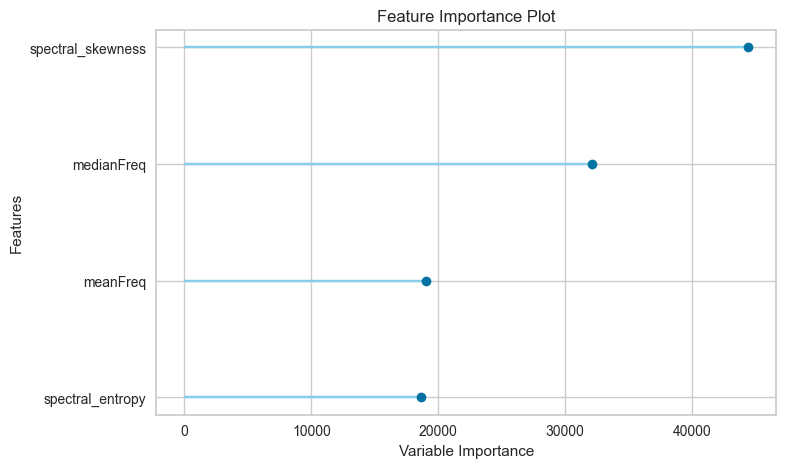

In [30]:
plot_model(lightgbm, plot='feature')

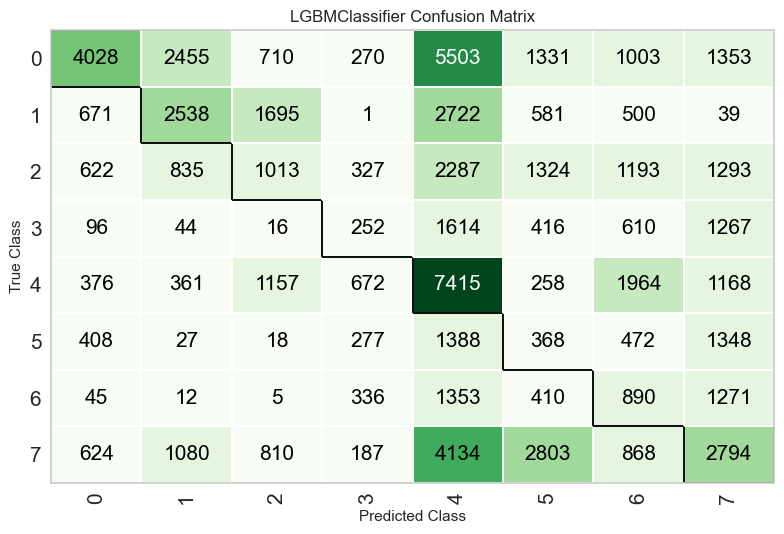

In [31]:
plot_model(lightgbm, plot='confusion_matrix')

In [32]:
predictions_lightgbm = predict_model(lightgbm, data = features_df_testing_normalized)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balance Acc,Hamming Loss,Jaccard Score,Log Loss
0,Light Gradient Boosting Machine,0.2606,0.5699,0.2606,0.3102,0.2574,0.1349,0.1398,0.2207,0.7394,0,26.6503


[LightGBM] [Warning] feature_fraction is set=0.42947671039481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42947671039481
[LightGBM] [Warning] bagging_fraction is set=0.8455104741417432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455104741417432
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.42947671039481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42947671039481
[LightGBM] [Warning] bagging_fraction is set=0.8455104741417432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455104741417432
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


In [33]:
predictions_lightgbm

,meanFreq,medianFreq,spectral_entropy,spectral_skewness,Label,prediction_label,prediction_score
93960,-1.250423,-1.624495,-0.464649,0.662564,micropitting,micropitting,1.0
371,0.700811,1.582892,-0.482752,-0.413348,healthy,pitting,1.0
33266,-0.071259,-0.063264,-0.482801,0.857047,healthy,teeth_break,1.0
238774,-0.543695,-0.242809,-0.255165,-0.833513,teeth_crack,wear,1.0
210317,-0.584476,-0.223067,-0.445249,-0.970789,missing_teeth,missing_teeth,1.0
...,...,...,...,...,...,...,...
241132,-0.542780,-0.229193,-0.436347,-0.543786,teeth_crack,teeth_break,1.0
214791,-0.575204,-0.216777,-0.428352,-0.330569,missing_teeth,missing_teeth,1.0
165165,1.900277,1.888254,0.105598,-2.297781,pitting,pitting,1.0
217690,0.181994,-0.199653,0.050038,-0.470341,missing_teeth,wear,1.0


In [34]:
get_incorrect_predictions(predictions_lightgbm)

,meanFreq,medianFreq,spectral_entropy,spectral_skewness,Label,prediction_label,prediction_score


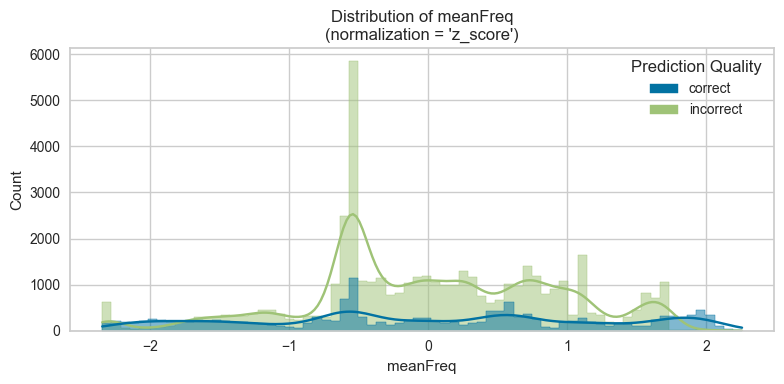

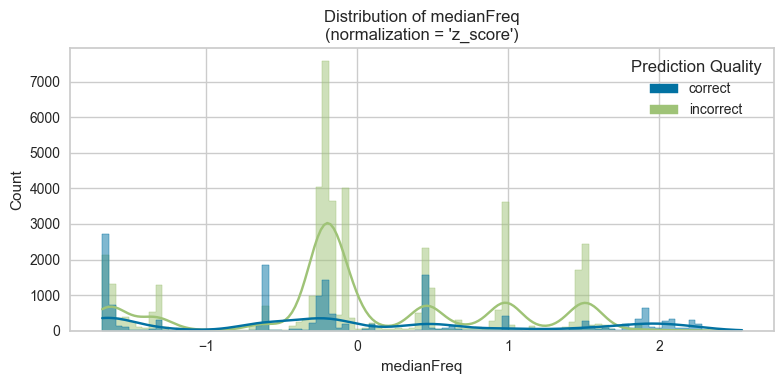

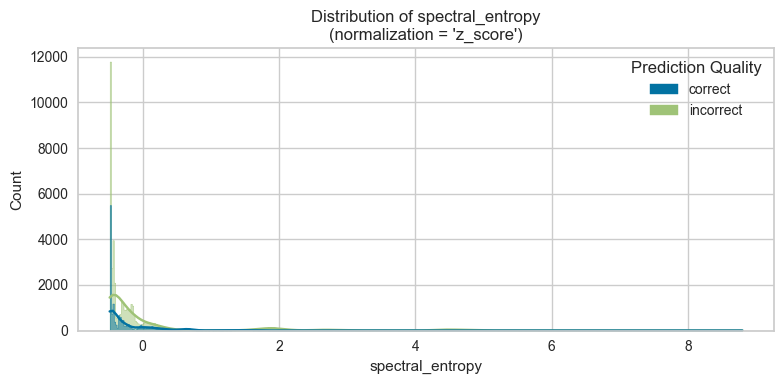

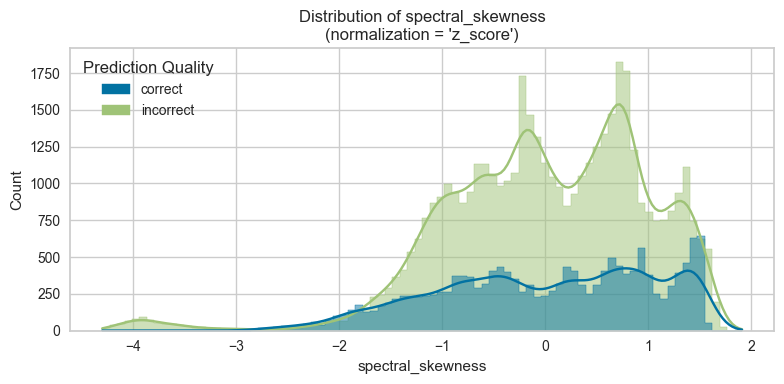

In [35]:
plotPredictionHistograms(predictions_lightgbm, normalization_method)

## Random Forest Classifier

In [36]:
bestParamsRF = {
    'bootstrap':True, 
    'ccp_alpha':0.0, 
    'class_weight':None,
    'criterion':'gini', 
    'max_depth':None, 
    'max_features':'sqrt',
    'max_leaf_nodes':None, 
    'max_samples':None,
    'min_impurity_decrease':0.0, 
    'min_samples_leaf':1,
    'min_samples_split':2, 
    'min_weight_fraction_leaf':0.0,
    'monotonic_cst':None, 
    'n_estimators':100, 
    'n_jobs':-1,
    'oob_score':False, 
    'random_state':1768, 
    'verbose':False,
    'warm_start':False
}

In [37]:
rf = create_model('rf', **bestParamsRF)

Traceback (most recent call last):
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1334, in _read_hel

In [38]:
evaluate_model(rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [39]:
rf_top_features = get_feature_importance_df(rf, features_df_training_normalized)
rf_top_features

,Features,importance
0,spectral_entropy,0.357487
1,medianFreq,0.261723
2,meanFreq,0.211395
3,spectral_skewness,0.169395


In [40]:
add_top_features(rf_top_features, top_n=3)

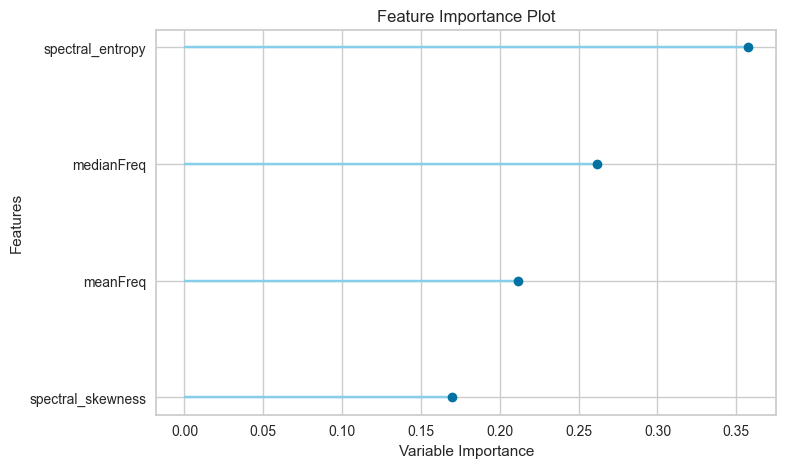

In [41]:
plot_model(rf, plot='feature')

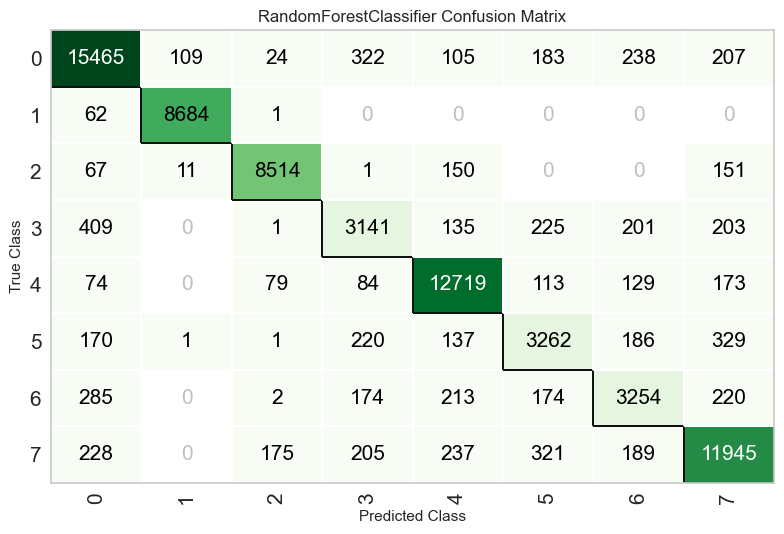

In [42]:
plot_model(rf, plot='confusion_matrix')

In [43]:
predictions_rf = predict_model(rf, data = features_df_testing_normalized)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balance Acc,Hamming Loss,Jaccard Score,Log Loss
0,Random Forest Classifier,0.9075,0.9923,0.9075,0.9070,0.9072,0.8905,0.8905,0.8748,0.0925,0,0.3294


In [44]:
get_incorrect_predictions(predictions_rf)

,meanFreq,medianFreq,spectral_entropy,spectral_skewness,Label,prediction_label,prediction_score


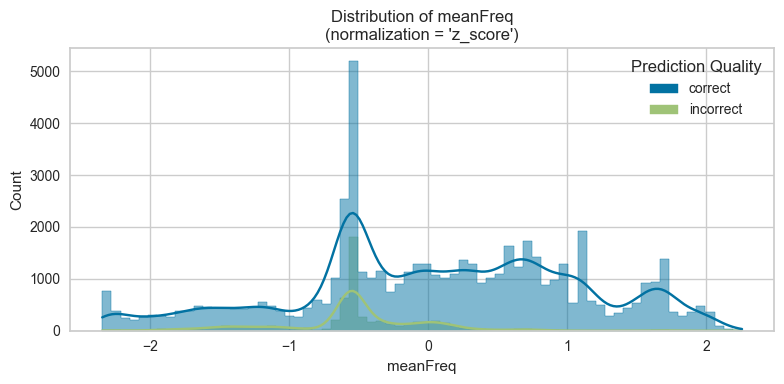

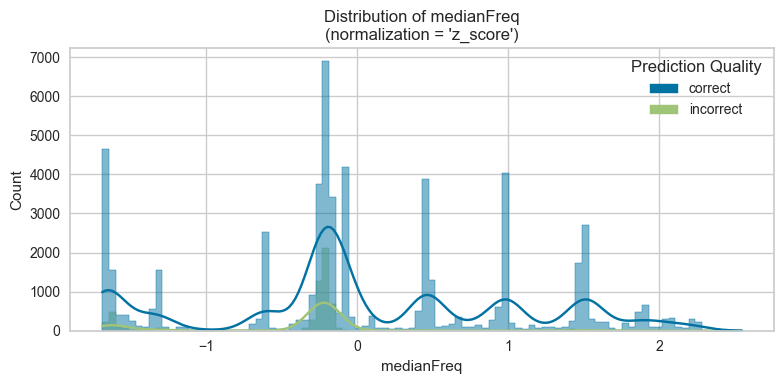

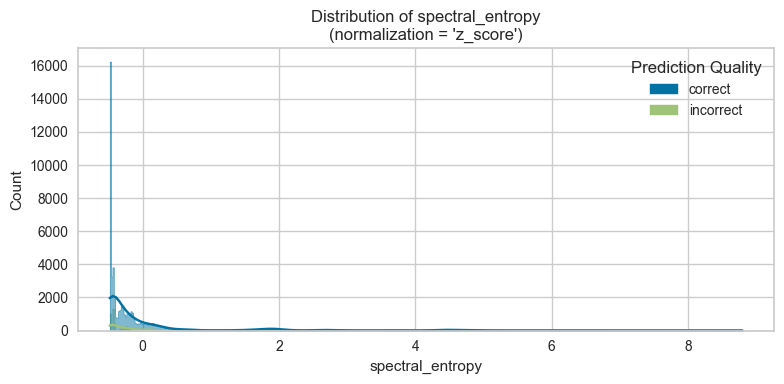

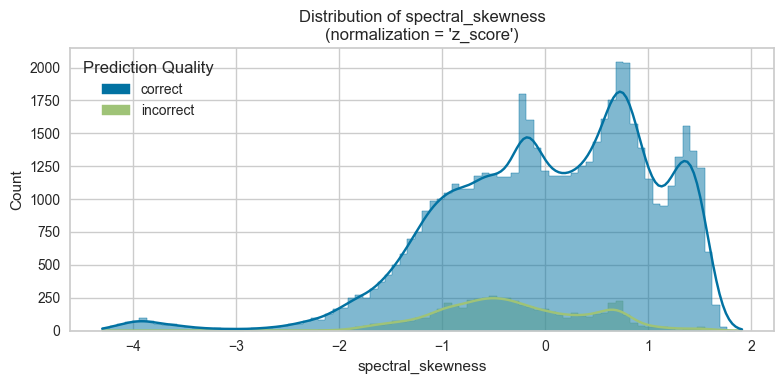

In [45]:
plotPredictionHistograms(predictions_rf, normalization_method)

## SVM

In [46]:
bestParamsSVM = {
    'alpha':1.983570694577895e-06, 
    'average':False, 
    'class_weight':None,
    'early_stopping':False, 
    'epsilon':0.1, 
    'eta0':0.050879465480455605,
    'fit_intercept':True, 
    'l1_ratio':0.3264919553269943,
    'learning_rate':'adaptive', 
    'loss':'hinge', 
    'max_iter':1000,
    'n_iter_no_change':5, 
    'n_jobs':-1, 
    'penalty':'l2', 
    'power_t':0.5,
    'random_state':1768, 
    'shuffle':True, 
    'tol':0.001,
    'validation_fraction':0.1, 
    'verbose':False, 
    'warm_start':False
}

In [47]:
svm = create_model('svm', **bestParamsSVM)

Traceback (most recent call last):
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1334, in _read_hel

In [48]:
evaluate_model(svm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

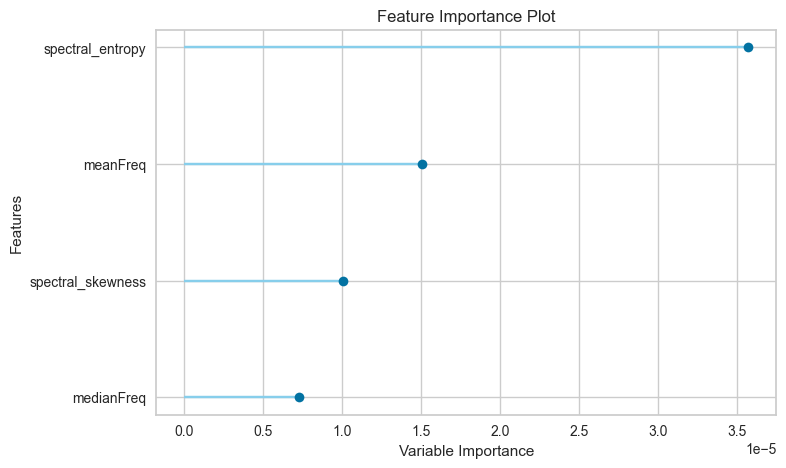

In [49]:
plot_model(svm, plot='feature')

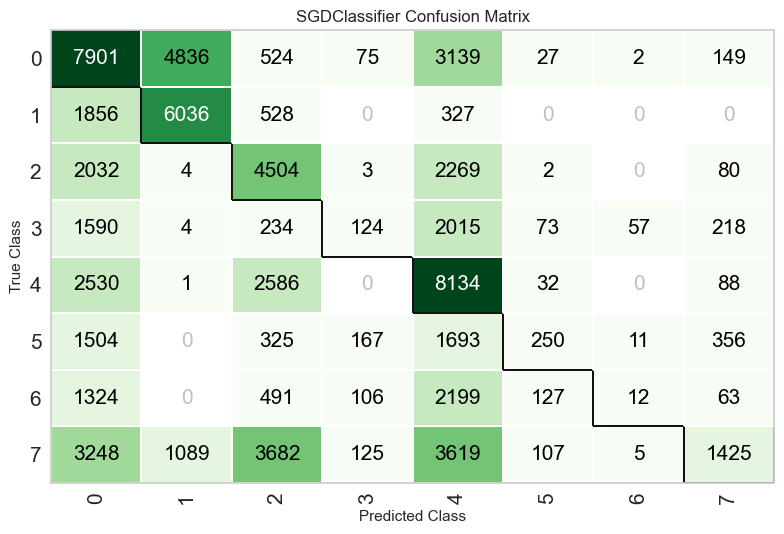

In [50]:
plot_model(svm, plot='confusion_matrix')

In [51]:
predictions_svm = predict_model(svm, data=features_df_testing_normalized)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balance Acc,Hamming Loss,Jaccard Score,Log Loss
0,SVM - Linear Kernel,0.3835,0,0.3835,0.3970,0.3326,0.2563,0.2662,0.3085,0.6165,0,0


In [52]:
get_incorrect_predictions(predictions_svm)

,meanFreq,medianFreq,spectral_entropy,spectral_skewness,Label,prediction_label


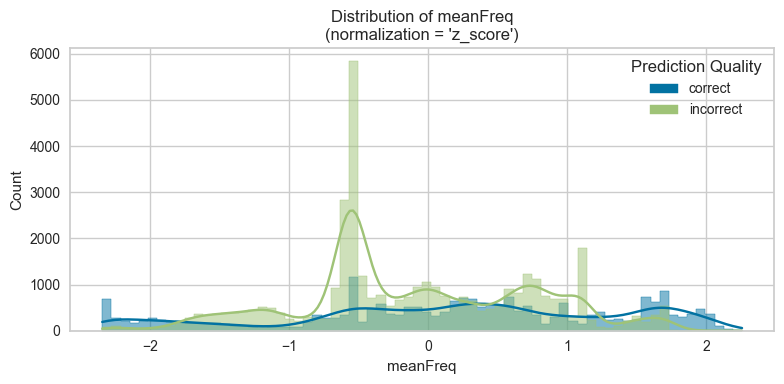

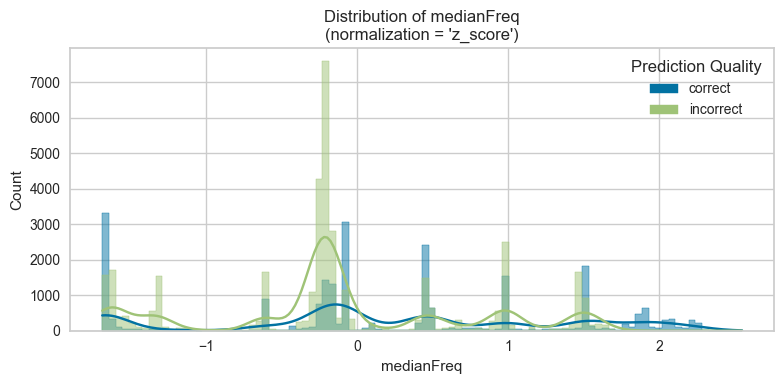

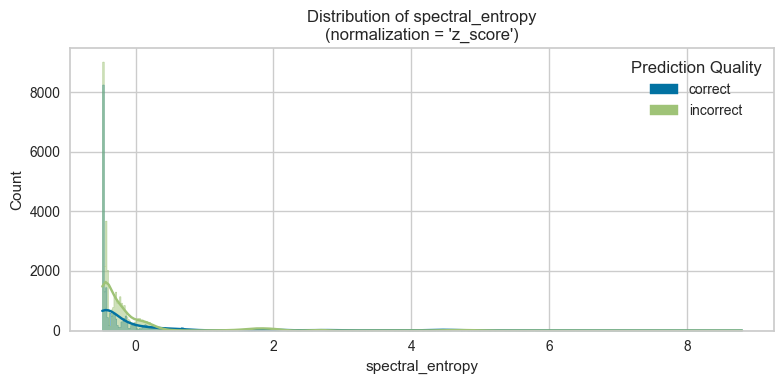

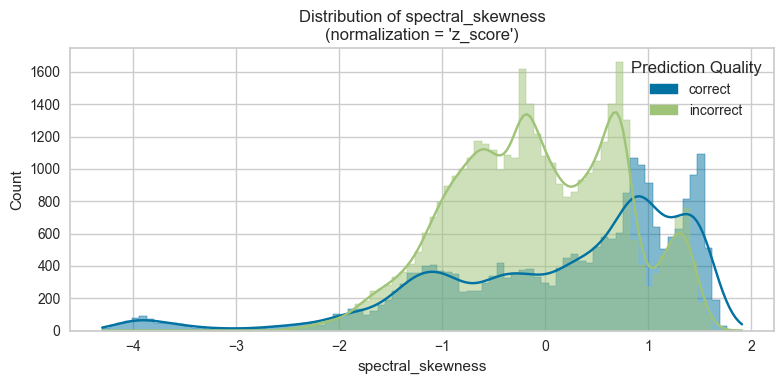

In [53]:
plotPredictionHistograms(predictions_svm, normalization_method)

# Experiment Setup (DL)

## Configure Data

In [54]:
train, test = train_test_split(normalized_df, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)
print(f"Train Shape: {train.shape} | Val Shape: {val.shape} | Test Shape: {test.shape}")

Train Shape: (197087, 5) | Val Shape: (49272, 5) | Test Shape: (61590, 5)


In [55]:
target = "Label"
num_labels = normalized_df['Label'].nunique()

categorical_cols = [
    col
    for col in features_df_training_normalized.select_dtypes(include=["object","category"]).columns
    if col != target
]

continuous_cols = features_df_training_normalized.select_dtypes(include=["number"]).columns.tolist()

In [56]:
print("Target:", target)
print("Categorical inputs:", categorical_cols)  
print("Continuous inputs:", continuous_cols)    

Target: Label
Categorical inputs: []
Continuous inputs: ['meanFreq', 'medianFreq', 'spectral_entropy', 'spectral_skewness']


In [57]:
data_config = DataConfig(
    target=[target],
    continuous_cols=continuous_cols,
    categorical_cols=categorical_cols,
)

In [58]:
available_gpu=1 if torch.cuda.is_available() else 0
print(f"Available GPU: {'Yes' if available_gpu else 'No'}")

Available GPU: Yes


In [59]:
trainer_config = TrainerConfig(
    auto_lr_find=False,
    max_epochs=10,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    batch_size=256,
)

optimizer_config = OptimizerConfig()

experiment_config = ExperimentConfig(
        project_name=experiment_name,
        run_name=f"{experiment_name}_run",
        log_target="tensorboard",
    )

In [60]:
tabnet_config = TabNetModelConfig(
        task="classification",
        n_d=33,
        n_a=46,
        n_steps=3,
        gamma=1.2864230491528987,
        embedding_dropout=0.1825276618254278,
        learning_rate=0.00468046516266798,
        metrics=[
            "accuracy", 
            "auroc",
            "recall",
            "precision",
            "f1_score",
            "cohen_kappa",
            "matthews_corrcoef",
            "hamming_distance",
            "jaccard_index",
        ],
        metrics_prob_input=[
            False,  #acc
            True,   # auroc
            False,  # recall
            False,  # precision
            False,  # f1_score
            False,  # cohen_kappa
            False,  # matthews_corrcoef
            False,  # hamming_distance
            False,  # jaccard_index
        ],
        metrics_params=[
            {"average": "macro"},
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # auroc
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # recall
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # precision
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # f1_score
            {"num_classes": normalized_df['Label'].nunique()},                      # cohen_kappa
            {},                                      # matthews_corrcoef
            {},                                      # hamming_distance
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # jaccard_index
        ]
    )

In [61]:
tabnet_model = TabularModel(
        data_config=data_config,
        model_config=tabnet_config,
        optimizer_config=optimizer_config,
        trainer_config=trainer_config,
        verbose=True
    )

2025-10-05 18:41:44,854 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

In [62]:
tabnet_model.fit(train=train, validation=val)

Seed set to 42


2025-10-05 18:41:44,906 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-10-05 18:41:44,932 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-10-05 18:41:45,016 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: TabNetModel

2025-10-05 18:41:45,063 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-10-05 18:41:45,114 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _embedding_layer │ Identity         │      0 │ train │
│ 1 │ _backbone        │ TabNetBackbone   │  118 K │ train │
│ 2 │ _head            │ Identity         │      0 │ train │
│ 3 │ loss             │ CrossEntropyLoss │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 118 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 118 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 107                                                                                         
Modules in eval mode: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


2025-10-05 18:53:47,066 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-10-05 18:53:47,069 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

In [63]:
tabnet_pred_df = tabnet_model.predict(test)
tabnet_pred_df.head(10)
tabnet_result = tabnet_model.evaluate(test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7432050704956055     │
│        test_auroc         │    0.9574425220489502     │
│     test_cohen_kappa      │    0.6953590512275696     │
│       test_f1_score       │    0.7432050704956055     │
│   test_hamming_distance   │    0.25679492950439453    │
│    test_jaccard_index     │    0.5291895866394043     │
│         test_loss         │     0.632521390914917     │
│        test_loss_0        │     0.632521390914917     │
│  test_matthews_corrcoef   │    0.6970387101173401     │
│      test_precision       │    0.7432050704956055     │
│        test_recall        │    0.7432050704956055     │
└───────────────────────────┴───────────────────────────┘

## GANDALF

In [64]:
gandalf_config = GANDALFConfig(
        task="classification",
        gflu_stages=8,
        gflu_dropout=0.20621973444441227,
        gflu_feature_init_sparsity=0.5069371167197942,
        learnable_sparsity=False,
        embedding_dropout= 0.06647823724375934,
        batch_norm_continuous_input=False,
        learning_rate=2.6124262014312122e-05,
        metrics=[
            "accuracy", 
            "auroc",
            "recall",
            "precision",
            "f1_score",
            "cohen_kappa",
            "matthews_corrcoef",
            "hamming_distance",
            "jaccard_index",
        ],
        metrics_prob_input=[
            False,  #acc
            True,   # auroc
            False,  # recall
            False,  # precision
            False,  # f1_score
            False,  # cohen_kappa
            False,  # matthews_corrcoef
            False,  # hamming_distance
            False,  # jaccard_index
        ],
        metrics_params=[
            {"average": "macro"},
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # auroc
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # recall
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # precision
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # f1_score
            {"num_classes": normalized_df['Label'].nunique()},                      # cohen_kappa
            {},                                      # matthews_corrcoef
            {},                                      # hamming_distance
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # jaccard_index
        ]
    )

In [65]:
gandalf_model = TabularModel(
    data_config=data_config,
    model_config=gandalf_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
    verbose=True
)

2025-10-05 18:54:06,111 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

In [66]:
gandalf_model.fit(train=train, validation=val)

Seed set to 42


2025-10-05 18:54:06,156 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-10-05 18:54:06,183 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-10-05 18:54:06,277 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-10-05 18:54:06,324 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-10-05 18:54:06,344 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │    904 │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │      0 │ train │
│ 2 │ _head            │ Sequential       │     48 │ train │
│ 3 │ loss             │ CrossEntropyLoss │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 944                                                                                              
Non-trainable params: 8                                                                                            
Total params: 952                                                                                                  
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 30                                                                                          
Modules in eval mode: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


2025-10-05 19:05:18,557 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-10-05 19:05:18,559 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

In [67]:
gandalf_pred_df = gandalf_model.predict(test)
gandalf_pred_df.head(10)

,Label_healthy_probability,Label_light_micropitting_probability,Label_micropitting_probability,Label_missing_teeth_probability,Label_pitting_probability,Label_teeth_break_probability,Label_teeth_crack_probability,Label_wear_probability,Label_prediction
93960,0.221170,0.174586,0.157763,0.053034,0.092095,0.075180,0.051701,0.174472,healthy
371,0.201649,0.194995,0.120050,0.045273,0.123784,0.063536,0.045628,0.205085,wear
33266,0.246254,0.203093,0.109171,0.040460,0.097541,0.080859,0.037617,0.185006,healthy
238774,0.129914,0.174484,0.189664,0.078677,0.107723,0.060855,0.092345,0.166338,micropitting
210317,0.125333,0.185351,0.182105,0.081101,0.106275,0.063966,0.094761,0.161106,light_micropitting
16,0.158276,0.193745,0.140334,0.057565,0.132827,0.057638,0.061922,0.197693,wear
117119,0.263844,0.183526,0.124932,0.041324,0.090366,0.079620,0.037193,0.179195,healthy
258524,0.209989,0.169779,0.170483,0.057161,0.090235,0.074450,0.057188,0.170714,healthy
226017,0.101268,0.162604,0.204522,0.088745,0.117338,0.050163,0.112028,0.163331,micropitting
6208,0.113714,0.177560,0.180548,0.078636,0.141405,0.046100,0.085779,0.176259,micropitting


In [68]:
gandalf_result = gandalf_model.evaluate(test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.2792336344718933     │
│        test_auroc         │    0.6912372708320618     │
│     test_cohen_kappa      │    0.12402284890413284    │
│       test_f1_score       │    0.2792336344718933     │
│   test_hamming_distance   │    0.7207663655281067     │
│    test_jaccard_index     │    0.09350568801164627    │
│         test_loss         │    1.8752975463867188     │
│        test_loss_0        │    1.8752975463867188     │
│  test_matthews_corrcoef   │    0.13118579983711243    │
│      test_precision       │    0.2792336344718933     │
│        test_recall        │    0.2792336344718933     │
└───────────────────────────┴───────────────────────────┘

In [69]:
gandalf_top_features = gandalf_model.feature_importance().sort_values("importance", ascending=False)
gandalf_top_features

,Features,importance
0,meanFreq,2.280675
2,spectral_entropy,2.233543
3,spectral_skewness,2.105096
1,medianFreq,1.380686


In [70]:
add_top_features(gandalf_top_features, top_n=3)

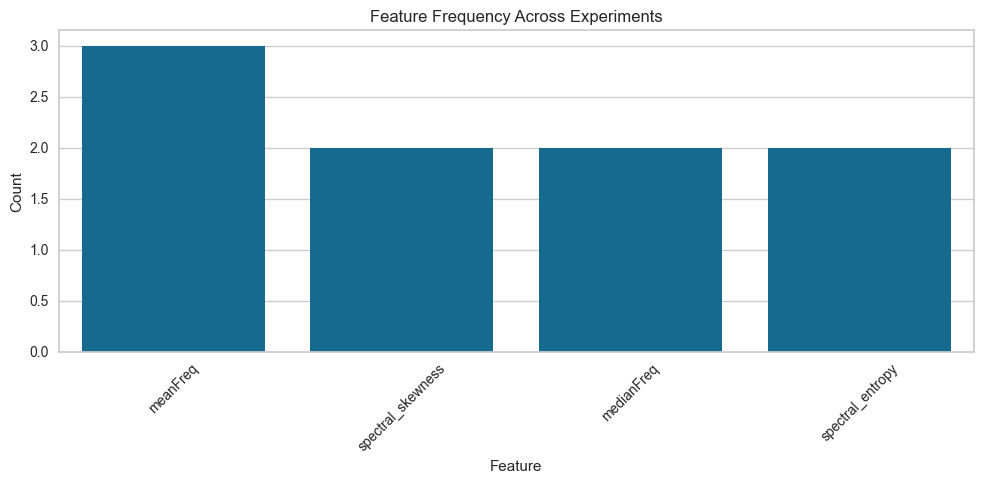

In [71]:
plot_feature_importance()